In [1]:
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts
import pandas as pd  
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot

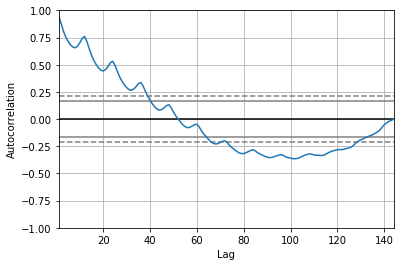

In [3]:
dataframe = pd.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = np.array(dataset.astype('float32'))

autocorrelation_plot(dataset)

In [5]:
corr=[]
for i in range(0,len(dataset)):
    #print(i,pd.Series(dataset.T[0]).autocorr(lag=i))
    corr.append(pd.Series(dataset.T[0]).autocorr(lag=i))

janela=(np.where(corr[1:-2]==np.max(corr[1:-2]))[0]+1)[0]
janela

12

In [6]:
X0=dataset[0:-12]
Y0=dataset[-12:]


def build_model(observed_time_series):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal = tfp.sts.Seasonal(
      num_seasons=12, observed_time_series=observed_time_series)
  model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
  return model

tf.reset_default_graph()
series_model = build_model(X0)

W0719 10:21:57.255133 139919590307584 linear_operator.py:940] Using (possibly slow) default implementation of to_dense.  Converts by self.matmul(identity).


In [7]:
with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
  elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
      series_model,
      observed_time_series=X0)
  
num_variational_steps = 300 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

train_vi = tf.train.AdamOptimizer(0.1).minimize(elbo_loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_variational_steps):
        _, elbo_ = sess.run((train_vi, elbo_loss))
        if i % 20 == 0:
            print("step {} -ELBO {}".format(i, elbo_))
    # Draw samples from the variational posterior.
    samples = sess.run({k: q.sample(50) for k, q in variational_posteriors.items()})

W0719 10:22:17.218127 139919590307584 deprecation.py:323] From /home/rubens/.local/lib/python3.7/site-packages/tensorflow_probability/python/internal/distribution_util.py:1846: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


step 0 -ELBO 859.264892578125
step 20 -ELBO 619.107666015625
step 40 -ELBO 596.1121826171875
step 60 -ELBO 588.6254272460938
step 80 -ELBO 584.3339233398438
step 100 -ELBO 583.0260009765625
step 120 -ELBO 574.337158203125
step 140 -ELBO 570.5248413085938
step 160 -ELBO 560.9597778320312
step 180 -ELBO 574.5689697265625
step 200 -ELBO 565.8952026367188
step 220 -ELBO 554.150146484375
step 240 -ELBO 563.2308959960938
step 260 -ELBO 555.3878173828125
step 280 -ELBO 558.3663940429688


In [8]:
component_dists = sts.decompose_by_component(
    series_model,
    observed_time_series=X0,
    parameter_samples=samples)


with tf.Session() as sess:
  series_component_means_, series_component_stddevs_ = sess.run(
      [{k.name: c.mean() for k, c in component_dists.items()},
       {k.name: c.stddev() for k, c in component_dists.items()}])

component_means_dict=series_component_means_ 
component_stddevs_dict=series_component_stddevs_


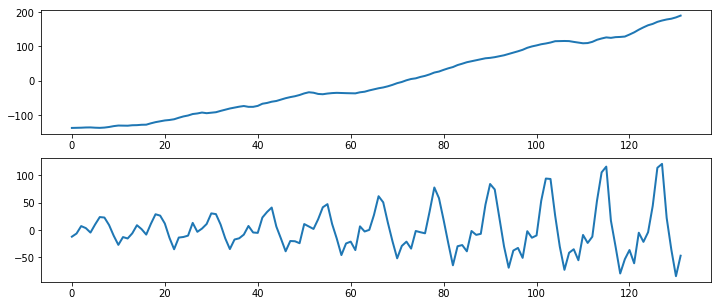

In [9]:
import collections

axes_dict = collections.OrderedDict()
num_components = len(component_means_dict)
fig = plt.figure(figsize=(12, 2.5 * num_components))
for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(np.arange(0,len(X0)), component_mean,lw=2)    

12


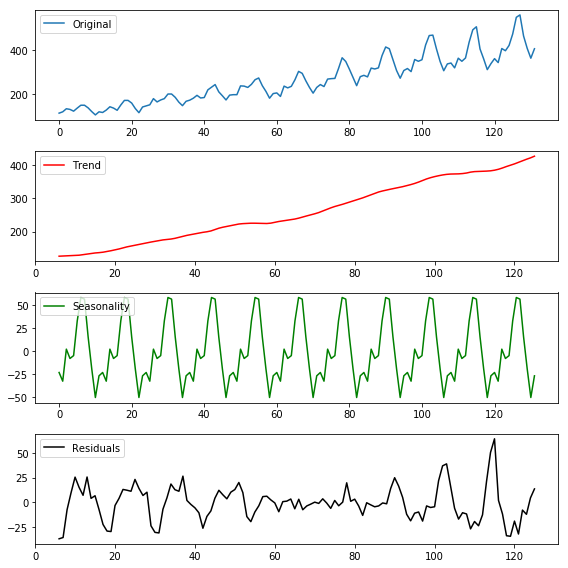

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(X0,freq=janela)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

z=np.where(seasonal==min(seasonal))[0]
period=z[2]-z[1]
print(period)

plt.figure(figsize=(8,8))
plt.subplot(411)
plt.plot(X0, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend',color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality',color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals',color='black')
plt.legend(loc='upper left')
plt.tight_layout()

In [11]:
print("Inferred parameters:")
for param in series_model.parameters:
    print("{}: {} +- {}".format(param.name,
                              np.mean(samples[param.name], axis=0),
                              np.std(samples[param.name], axis=0)))
num_forecast_steps=12
series_forecast_dist = tfp.sts.forecast(
    series_model,
    observed_time_series=X0,
    parameter_samples=samples,
    num_steps_forecast=num_forecast_steps)

series_forecast_dist

num_samples=10

with tf.Session() as sess:
  series_forecast_mean, series_forecast_scale, series_forecast_samples = sess.run(
      (series_forecast_dist.mean()[..., 0],
       series_forecast_dist.stddev()[..., 0],
       series_forecast_dist.sample(num_samples)[..., 0]))

Inferred parameters:
observation_noise_scale: 0.8333669900894165 +- 0.6655823588371277
LocalLinearTrend/_level_scale: 3.7781426906585693 +- 0.5336015820503235
LocalLinearTrend/_slope_scale: 0.31393420696258545 +- 0.21585135161876678
Seasonal/_drift_scale: 8.090559959411621 +- 0.6179745197296143


In [12]:
x=np.linspace(0,len(X0),len(X0))
num_steps = len(X0)
num_steps_forecast = series_forecast_mean.shape[-1]
num_steps_train = num_steps - num_steps_forecast
forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

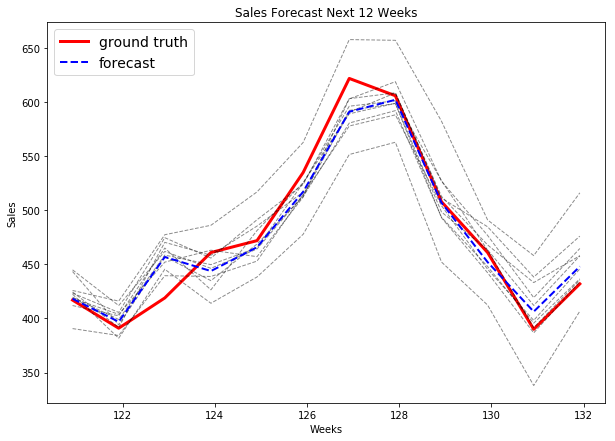

In [13]:
plt.figure(figsize=(10,7))
plt.plot(forecast_steps,Y0,color='red',label='ground truth',lw=3)
plt.plot(forecast_steps, series_forecast_samples.T, lw=1,ls='--',color='black', alpha=0.45)
plt.plot(forecast_steps, series_forecast_mean, lw=2, ls='--', color='blue',label='forecast')
plt.legend(loc=2,prop={'size': 14})
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.title('Sales Forecast Next 12 Weeks')
plt.show()